In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
!pip install currencyconverter==0.16.3

# 2.1 Getting your data + feature engineering

In [3]:
data = pd.read_csv("/Users/giosc/Desktop/Giovanni/Università/ADM/Homework_4/bank_transactions.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [5]:
# MISSING VALUES
data.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [6]:
#DROP THE MISSING VALUES
data.dropna(inplace=True)
data.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [7]:
data.CustomerDOB = pd.to_datetime(data.CustomerDOB) #cast from type object to type date
data.TransactionDate = pd.to_datetime(data.TransactionDate) # #cast type from object to type date
data.TransactionTime = data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S')) #cast from type int64 to type date

In [8]:
# Drop the customers born in 1800 and other invalid dates
data.drop(data[data.CustomerDOB.dt.year==1800].index,axis=0,inplace=True)
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

In [9]:
data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,1900-01-01 14:27:14,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,1900-01-01 18:11:56,1762.5
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-08-04,M,NEW DELHI,7635.19,2016-09-18,1900-01-01 18:48:24,799.0
1048563,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,1900-01-01 18:37:34,460.0
1048564,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,1900-01-01 18:33:13,770.0
1048565,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,1900-01-01 18:47:06,1000.0


- Sometimes, the features (variables, fields) are not given in a dataset but can be created from it. The previous step is known as feature engineering. For example, the original dataset has several transactions done by the same customer. Then, we suggest you to group data by the client (using CustomerId) and, based on it, create the following new features for each CustomerId:

In [10]:
df = pd.DataFrame()
df["CustomerID"]= data.groupby("CustomerID", as_index=False)["CustomerID"].first()

In [11]:
# a) Number of transactions
df["#Transactions"] = data.groupby("CustomerID", as_index=False)["TransactionID"].count()["TransactionID"]

In [12]:
from currency_converter import CurrencyConverter

# Convert INR in USD
c = CurrencyConverter()
def convert(v):
    result=c.convert(v, 'INR', 'USD')
    return result
data['TransactionAmount (USD)']=data['TransactionAmount (INR)'].map(convert).astype(int)
data['CustAccountBalance (USD)']=round(data['CustAccountBalance'].map(convert),2)

# b) Number of transactions with a balance bigger than 100 USD
df_filter = data
df_filter["filter"] = data["TransactionAmount (USD)"] > 100
df_filter['filter']=df_filter['filter'].replace({False: 0, True: 1})
df["#TransactionsBigger100 (USD)"]= df_filter.groupby("CustomerID", as_index=False)['filter'].sum()['filter']

In [13]:
# c) Average amount of the transactions
df["Avg TransactionAmount"]= data.groupby("CustomerID", as_index=False)["TransactionAmount (USD)"].mean()["TransactionAmount (USD)"]

In [14]:
# d) Average balance
df["AverageBalance"] = data.groupby("CustomerID", as_index=False)["CustAccountBalance (USD)"].mean()["CustAccountBalance (USD)"]

In [15]:
# e) Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation).
df['Utilisation'] = (df['AverageBalance'] - df['Avg TransactionAmount'])

In [16]:
# f) Most common gender of the customer (0 = male, 1 = Female, 2 = both)

data["CustGender"].replace("M", 0, inplace=True)
data["CustGender"].replace("F", 1, inplace=True)
data["CustGender"].replace("T", 0, inplace=True) #Invalid value "T" set to 0
df["CommonGender"]=data.groupby('CustomerID', as_index=False)["CustGender"].mean()["CustGender"]
df['CommonGender']=pd.cut(x=df['CommonGender'],bins=[-1,0.49,0.51,2],labels=[0,2,1])

In [17]:
# h) Most frequent location of the customer
df["CommonCustLocation"]=data.groupby("CustomerID", as_index=False)["CustLocation"].agg(pd.Series.mode)["CustLocation"]


In [18]:
df

,CustomerID,#Transactions,#TransactionsBigger100 (USD),Avg TransactionAmount,AverageBalance,Utilisation,CommonGender,CommonCustLocation
0,C1010011,2,0,33.5,1022.105,988.605,2,"[NEW DELHI, NOIDA]"
1,C1010012,1,0,20.0,324.070,304.070,0,MUMBAI
2,C1010014,2,0,9.5,1340.385,1330.885,2,MUMBAI
3,C1010018,1,0,0.0,6.640,6.640,1,CHAMPARAN
4,C1010024,1,0,66.0,1165.610,1099.610,0,KOLKATA
...,...,...,...,...,...,...,...,...
839076,C9099836,1,0,9.0,1781.600,1772.600,0,BHIWANDI
839077,C9099877,1,0,2.0,1286.170,1284.170,0,BANGALORE
839078,C9099919,1,0,1.0,74.440,73.440,0,GUNTUR
839079,C9099941,1,0,0.0,472.570,472.570,0,CHENNAI


- Consider at least 20 additional features that can be generated for each CustomerId. Describe each of them and why you believe they will be helpful. Moreover, add it to the previous dataset (the one with seven features). In the end, you should have for each CustomerID at least 27 features (7 recommended + 20 suggested by you).

In [19]:
# MIN TRANSACTION AMOUNT FOR EACH CUSTOMERID
df["MinTransactionAmount"] = data.groupby("CustomerID", as_index=False)["TransactionAmount (USD)"].min()["TransactionAmount (USD)"]

In [20]:
# MAX TRANSACTION AMOUNT FOR EACH CUSTOMERID 
df["MaxTransactionAmount"] = data.groupby("CustomerID", as_index=False)["TransactionAmount (USD)"].max()["TransactionAmount (USD)"]

In [21]:
# TOT TRANSACTION AMOUNT FOR EACH CUSTOMERID
df["TotTransactionAmount"] = data.groupby("CustomerID", as_index=False)["TransactionAmount (USD)"].sum()["TransactionAmount (USD)"]

In [22]:
# TOTAL OF TRANSACTIONS AMOUNT IN MOST COMMON CUSTOMERS LOCATION
dt = data.groupby(["CustomerID", "CustLocation"], as_index=False)["TransactionAmount (USD)"].sum()
df["TotT_Amount_MostCommonLoc"]=dt.groupby("CustomerID", as_index=False)["TransactionAmount (USD)"].max()["TransactionAmount (USD)"]

In [23]:
# MIN ACCOUNT BALANCE
df["MinAccountBalance"]=data.groupby("CustomerID", as_index=False)["CustAccountBalance (USD)"].min()["CustAccountBalance (USD)"]

In [24]:
# MAX ACCOUNT BALANCE 
df["MaxAccountBalance"]=data.groupby("CustomerID", as_index=False)["CustAccountBalance (USD)"].max()["CustAccountBalance (USD)"]

In [25]:
# TOT ACCOUNT BALANCE 
df["TotAccountBalance"] = data.groupby("CustomerID", as_index=False)["CustAccountBalance (USD)"].sum()["CustAccountBalance (USD)"]

In [26]:
# QUARTILE 1 OF TRANSACTION AMOUNT (USD) 
df["Q1Transaction"]=data.groupby('CustomerID', as_index=False)["TransactionAmount (USD)"].quantile(0.25)["TransactionAmount (USD)"]

In [27]:
## QUARTILE 2 OF TRANSACTION AMOUNT (USD) 
df["Q3Transaction"]=data.groupby('CustomerID', as_index=False)["TransactionAmount (USD)"].quantile(0.75)["TransactionAmount (USD)"]

In [28]:
# PERCENTAGE OF THE BANK'S TOTAL RESERVE HELD BY EACH CUSTOMER
reserve_tot = df["TotAccountBalance"].sum()
reserve_tot
df["CustomerReserve (%)"] = ((df["TotAccountBalance"] / reserve_tot)*100).round(4)

In [29]:
# TYPE OF COSTUMER BASED ON CUSTACCOUNTBALANCE (<5000 -> Bronze, >=5000 -> Silver, >=25000 -> Gold, >=100000 -> Premium)
labels = df
df["CustomerType"]= pd.cut(x=labels['TotAccountBalance'],bins=[0,5000,25000,100000,100000000],labels=['Bronze','Silver','Gold','Premium'])

In [30]:
# HOW FREQUENTLY THE BALANCE IS UPDATED, SCORE BETWEEN 0 AND 1 (1 = frequently updated, 0 = not frequently updated)
dtemp = data.groupby("CustomerID", as_index=False)["CustomerID"].first()
dtemp["#Balance"] = data.groupby("CustomerID", as_index=False)["CustAccountBalance (USD)"].count()["CustAccountBalance (USD)"]
df["BalanceFrequency"] = dtemp["#Balance"] / 6

In [31]:
# RATIO BETWEEN UTILISATION TO AVERAGE BALANCE
df["Utilisation/AvgBalance"] = df["Utilisation"] / df["AverageBalance"]

In [32]:
# RATIO BETWEEN UTILISATION TO AVERAGE BALANCE (%)
df["Utilisation/AvgBalance (%)"] = (((df["Utilisation"] / df["AverageBalance"])*100)).round(2)

In [33]:
# RATIO BETWEEN TOTAL TRANSACTIONS AMOUNT TO AVERAGE BALANCE
df["TotTransactionAmount/AvgBalance"] =df["TotTransactionAmount"] / df["AverageBalance"]

In [34]:
# RATIO BETWEEN TOTAL TRANSACTIONS AMOUNT TO AVERAGE BALANCE (%)
df["TotTransactionAmount/AvgBalance (%)"] = (((df["TotTransactionAmount"] / df["AverageBalance"])*100)).round(2)

In [35]:
# NUMBER OF TRANSACTIONS WITH A BALANCE LESSER THAN 100 USD
df_filter = data
df_filter["filter"] = data["TransactionAmount (USD)"] < 100
df_filter['filter']=df_filter['filter'].replace({False: 0, True: 1})
df["#TransactionsLesser100 (USD)"]= df_filter.groupby("CustomerID", as_index=False)['filter'].sum()['filter']

In [36]:
# CUSTOMER AGE
df['CustomerAge'] = (( pd.to_datetime('today') - data.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)

In [37]:
# CLASSIFYNG CUSTOMER AGE (<=25 -> Young, >25 -> Adult, >60 -> Old)
df['Age_Class']=pd.cut(x=df.CustomerAge,bins=[0,25,60,200],labels=['Young','Adult','Old'])

In [38]:
# CUSTOMER ID WITH MORE THAN ONE GENDER ARE PROBABLY MARRIED OR COHABITING. SINGLE CUSTOMER (with common gender=1 or 0) AND CUSTOMER MARRIED OR COHABITING (with common gender = 2)
df["SocialStatus"] = df['CommonGender'].replace({0:"Single", 1:'Single', 2:"Married"})

In [39]:
df.dropna(inplace=True)

In [40]:
df

,CustomerID,#Transactions,#TransactionsBigger100 (USD),Avg TransactionAmount,AverageBalance,Utilisation,CommonGender,CommonCustLocation,MinTransactionAmount,MaxTransactionAmount,...,CustomerType,BalanceFrequency,Utilisation/AvgBalance,Utilisation/AvgBalance (%),TotTransactionAmount/AvgBalance,TotTransactionAmount/AvgBalance (%),#TransactionsLesser100 (USD),CustomerAge,Age_Class,SocialStatus
0,C1010011,2,0,33.5,1022.105,988.605,2,"[NEW DELHI, NOIDA]",4,63,...,Bronze,0.333333,0.967225,96.72,0.065551,6.56,2,28.0,Adult,Married
1,C1010012,1,0,20.0,324.070,304.070,0,MUMBAI,20,20,...,Bronze,0.166667,0.938285,93.83,0.061715,6.17,1,66.0,Old,Single
2,C1010014,2,0,9.5,1340.385,1330.885,2,MUMBAI,3,16,...,Bronze,0.333333,0.992912,99.29,0.014175,1.42,2,26.0,Adult,Married
3,C1010018,1,0,0.0,6.640,6.640,1,CHAMPARAN,0,0,...,Bronze,0.166667,1.000000,100.00,0.000000,0.00,1,49.0,Adult,Single
4,C1010024,1,0,66.0,1165.610,1099.610,0,KOLKATA,66,66,...,Bronze,0.166667,0.943377,94.34,0.056623,5.66,1,35.0,Adult,Single
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839075,C9099832,1,0,7.0,117.180,110.180,0,GHAZIABAD,7,7,...,Bronze,0.166667,0.940263,94.03,0.059737,5.97,1,49.0,Adult,Single
839076,C9099836,1,0,9.0,1781.600,1772.600,0,BHIWANDI,9,9,...,Bronze,0.166667,0.994948,99.49,0.005052,0.51,1,27.0,Adult,Single
839077,C9099877,1,0,2.0,1286.170,1284.170,0,BANGALORE,2,2,...,Bronze,0.166667,0.998445,99.84,0.001555,0.16,1,35.0,Adult,Single
839078,C9099919,1,0,1.0,74.440,73.440,0,GUNTUR,1,1,...,Bronze,0.166667,0.986566,98.66,0.013434,1.34,1,44.0,Adult,Single


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785492 entries, 0 to 839079
Data columns (total 28 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   CustomerID                           785492 non-null  object  
 1   #Transactions                        785492 non-null  int64   
 2   #TransactionsBigger100 (USD)         785492 non-null  int64   
 3   Avg TransactionAmount                785492 non-null  float64 
 4   AverageBalance                       785492 non-null  float64 
 5   Utilisation                          785492 non-null  float64 
 6   CommonGender                         785492 non-null  category
 7   CommonCustLocation                   785492 non-null  object  
 8   MinTransactionAmount                 785492 non-null  int64   
 9   MaxTransactionAmount                 785492 non-null  int64   
 10  TotTransactionAmount                 785492 non-null  int64   
 11  

# 2.2 Choose your features (variables)!

Principal Component Analysis (PCA) is a linear dimensionality reduction technique that can be utilized for extracting information from a high-dimensional space by projecting it into a lower-dimensional sub-space. It tries to preserve the essential parts that have more variation of the data and remove the non-essential parts with fewer variation.

Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales. Let us continue with the transformation of the data onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms.

In [42]:
# Check correlation between features
pearsoncorr = df.corr(method='pearson')
pearsoncorr

,#Transactions,#TransactionsBigger100 (USD),Avg TransactionAmount,AverageBalance,Utilisation,MinTransactionAmount,MaxTransactionAmount,TotTransactionAmount,TotT_Amount_MostCommonLoc,MinAccountBalance,...,Q1Transaction,Q3Transaction,CustomerReserve (%),BalanceFrequency,Utilisation/AvgBalance,Utilisation/AvgBalance (%),TotTransactionAmount/AvgBalance,TotTransactionAmount/AvgBalance (%),#TransactionsLesser100 (USD),CustomerAge
#Transactions,1.000000,0.070970,-0.000607,0.000191,0.000195,-0.064198,0.067591,0.091629,0.068806,-0.040737,...,-0.037783,0.028821,0.052294,1.000000,0.009491,0.009491,-0.008899,-0.008899,0.916096,-0.001014
#TransactionsBigger100 (USD),0.070970,1.000000,0.517147,0.045926,0.041942,0.451881,0.553235,0.558490,0.553490,0.038000,...,0.484010,0.538179,0.052380,0.070970,-0.037945,-0.037945,0.038224,0.038224,-0.331486,0.000837
Avg TransactionAmount,-0.000607,0.517147,1.000000,0.050862,0.043143,0.972971,0.969506,0.964820,0.969225,0.049544,...,0.991257,0.994095,0.048719,-0.000607,-0.040443,-0.040443,0.040518,0.040518,-0.207815,0.000516
AverageBalance,0.000191,0.045926,0.050862,1.000000,0.999970,0.048638,0.049973,0.050138,0.049993,0.961087,...,0.050035,0.050976,0.960653,0.000191,0.003402,0.003402,-0.003433,-0.003433,-0.018295,-0.000535
Utilisation,0.000195,0.041942,0.043143,0.999970,1.000000,0.041127,0.042490,0.042691,0.042512,0.961053,...,0.042384,0.043303,0.960626,0.000195,0.003716,0.003716,-0.003747,-0.003747,-0.016694,-0.000539
MinTransactionAmount,-0.064198,0.451881,0.972971,0.048638,0.041127,1.000000,0.889665,0.882231,0.889325,0.052986,...,0.993820,0.942402,0.040180,-0.064198,-0.041972,-0.041972,0.041871,0.041871,-0.241697,0.000349
MaxTransactionAmount,0.067591,0.553235,0.969506,0.049973,0.042490,0.889665,1.000000,0.998428,0.999789,0.043210,...,0.928888,0.987994,0.054547,0.067591,-0.036582,-0.036582,0.036832,0.036832,-0.157878,0.000748
TotTransactionAmount,0.091629,0.558490,0.964820,0.050138,0.042691,0.882231,0.998428,1.000000,0.998638,0.041986,...,0.922598,0.984692,0.056567,0.091629,-0.036042,-0.036042,0.036310,0.036310,-0.137309,0.000638
TotT_Amount_MostCommonLoc,0.068806,0.553490,0.969225,0.049993,0.042512,0.889325,0.999789,0.998638,1.000000,0.043169,...,0.928575,0.987747,0.054681,0.068806,-0.036547,-0.036547,0.036800,0.036800,-0.156834,0.000750
MinAccountBalance,-0.040737,0.038000,0.049544,0.961087,0.961053,0.052986,0.043210,0.041986,0.043169,1.000000,...,0.051756,0.047020,0.854791,-0.040737,0.003072,0.003072,-0.003101,-0.003101,-0.053771,-0.000599


Let's plot for a better visualization

<AxesSubplot:>

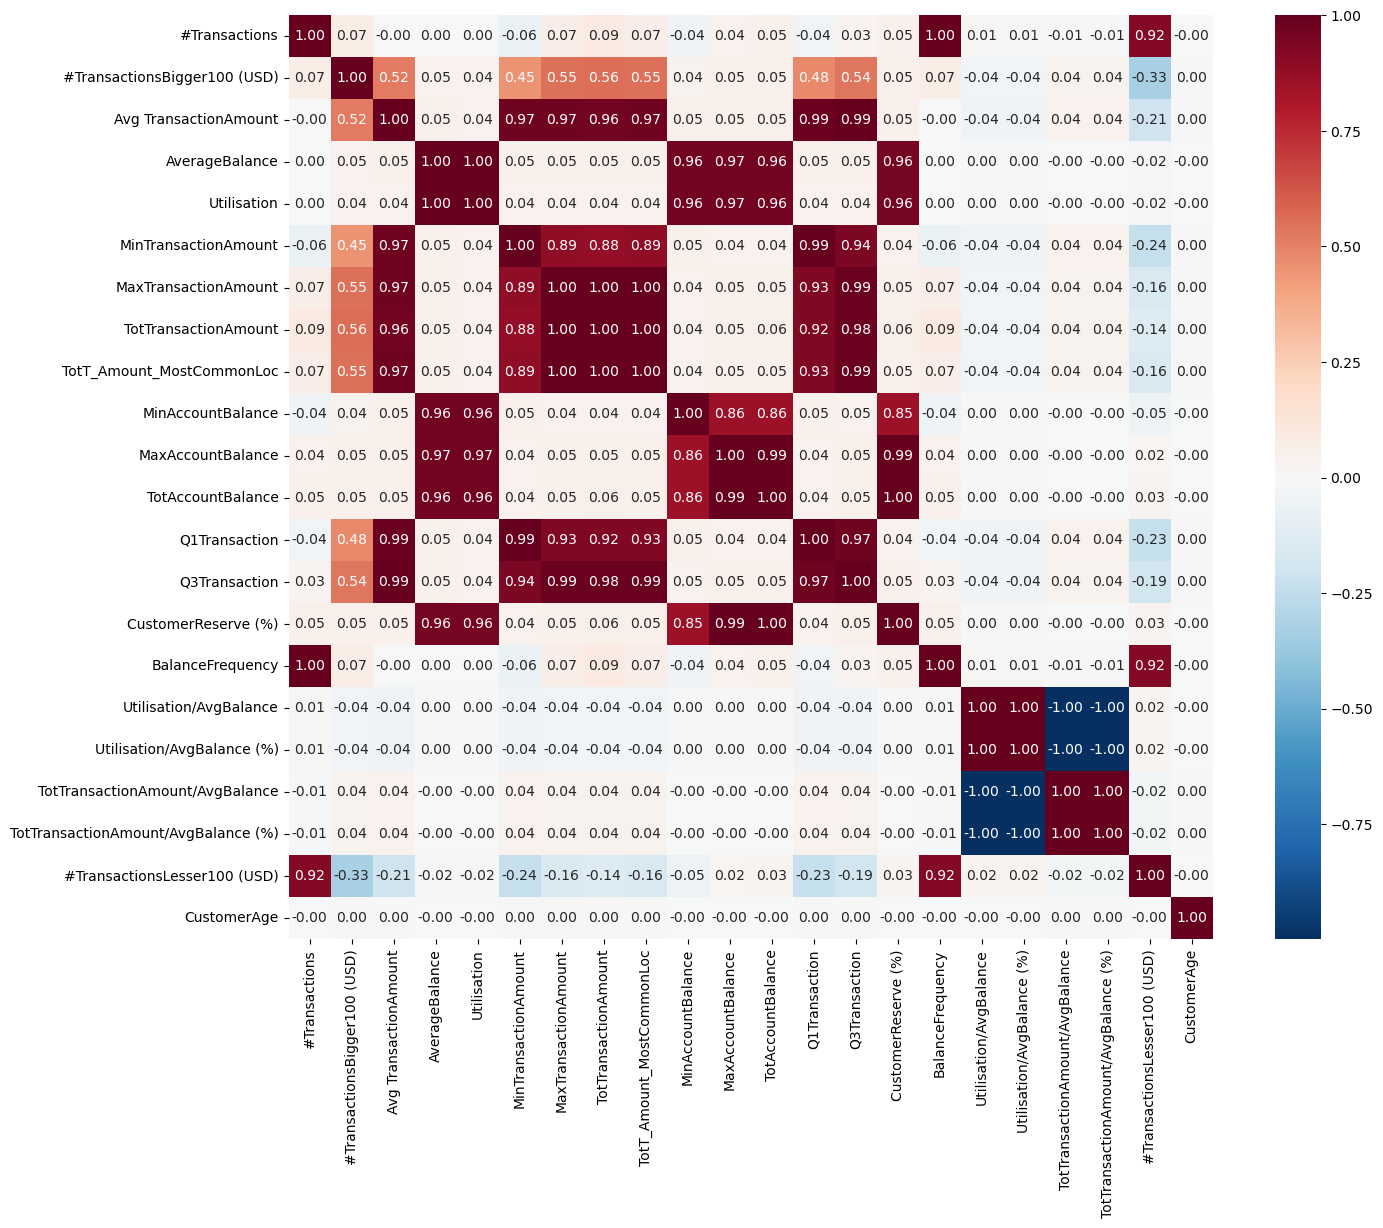

In [43]:
plt.figure(figsize=(16,12))

sns.heatmap(pearsoncorr, center=0, annot=True,
             fmt='.2f', square=True, cmap='RdBu_r')

In [44]:
df_stand = pd.DataFrame(df[['#Transactions','#TransactionsBigger100 (USD)','Avg TransactionAmount','AverageBalance','Utilisation','MinTransactionAmount','MaxTransactionAmount','TotAccountBalance','Q1Transaction','Q3Transaction','CustomerReserve (%)','BalanceFrequency','Utilisation/AvgBalance','TotTransactionAmount/AvgBalance','#TransactionsLesser100 (USD)','CustomerAge']])

In [45]:
# Standardize data
scaler = StandardScaler()
stand=scaler.fit_transform(df_stand)
stand

array([[ 1.89369457, -0.18821647,  0.17776773, ..., -0.02509016,
         1.86592955, -1.0652263 ],
       [-0.40147639, -0.18821647,  0.01239888, ..., -0.02511286,
        -0.30309813,  3.16051355],
       [ 1.89369457, -0.18821647, -0.11622133, ..., -0.02539421,
         1.86592955, -1.28763366],
       ...,
       [-0.40147639, -0.18821647, -0.20809292, ..., -0.0254689 ,
        -0.30309813, -0.28680054],
       [-0.40147639, -0.18821647, -0.22034246, ..., -0.0253986 ,
        -0.30309813,  0.71403258],
       [-0.40147639, -0.18821647, -0.232592  , ..., -0.0254781 ,
        -0.30309813,  0.71403258]])

In [46]:
stand = pd.DataFrame(stand)

In [47]:
pca = PCA().fit(stand)

Selecting the best number of principal components

In [48]:
# PC1 contributed 33%, PC2 contributed 24% and so on.
print(pca.explained_variance_ratio_.round(2)[:10])

[0.33 0.24 0.18 0.12 0.06 0.05 0.01 0.   0.   0.  ]


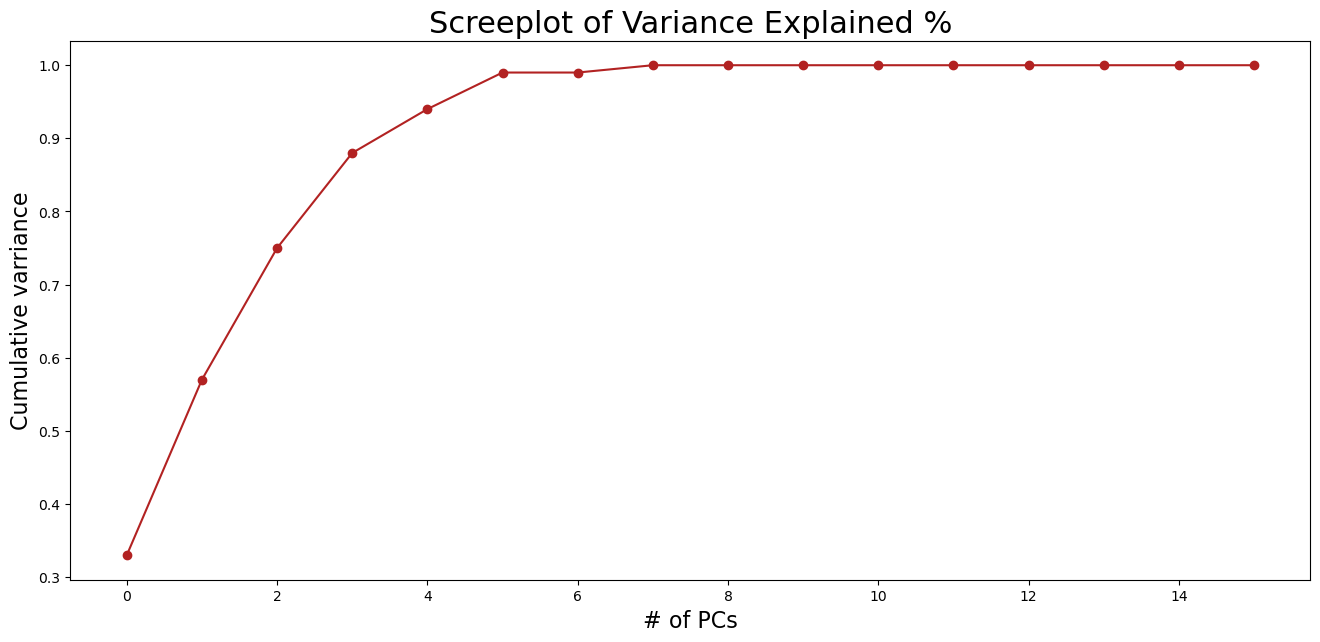

In [49]:
variance_exp_cumsum = pca.explained_variance_ratio_.cumsum().round(2)
fig, axes = plt.subplots(1,1,figsize=(16,7), dpi=100)
plt.plot(variance_exp_cumsum, marker = 'o',color='firebrick')
plt.title('Screeplot of Variance Explained %', fontsize=22)
plt.xlabel('# of PCs', fontsize=16)
plt.ylabel('Cumulative varriance', fontsize = 16)
plt.show()

In [134]:
pca1 = PCA(n_components=3)
PC = pca1.fit_transform(stand)
df_pca = pd.DataFrame(data = PC, columns = ['PC1', 'PC2', 'PC3'])

In [135]:
df_pca

,PC1,PC2,PC3
0,-0.069802,0.279170,3.292534
1,0.005253,-0.291060,-0.616912
2,-0.645829,0.481751,3.181510
3,-0.510154,-0.253351,-0.677062
4,1.199780,-0.302040,-0.476856
...,...,...,...
785487,-0.329977,-0.266325,-0.655442
785488,-0.234387,0.006935,-0.673379
785489,-0.422663,-0.032040,-0.690395
785490,-0.483459,-0.247986,-0.674225


In [70]:
# Explained variance for each principal component
print(pca1.explained_variance_ratio_.round(2))

[0.33 0.24 0.18]


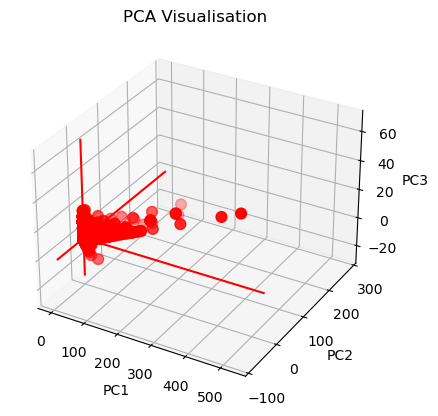

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c='red', cmap="Set2_r", s=60)
 
# make simple, bare axis lines through space:
xAxisLine = ((min(df_pca['PC1']), max(df_pca['PC1'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(df_pca['PC2']), max(df_pca['PC2'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(df_pca['PC3']), max(df_pca['PC3'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA Visualisation")
plt.show()

In [72]:
# Check correlation between features of the new reduced dataset 
pearsoncorr = df_pca.corr(method='pearson')
pearsoncorr

,PC1,PC2,PC3
PC1,1.000000e+00,7.959620e-16,2.653831e-16
PC2,7.959620e-16,1.000000e+00,-2.201168e-16
PC3,2.653831e-16,-2.201168e-16,1.000000e+00


# 2.3 Clustering!

We couldn't implement the kmeans algorithm with MapReduce so we tried it with a basic way from scratch.

In [138]:
d=df_pca[:10000]
colnames = list(df_pca.columns)
colnames

['PC1', 'PC2', 'PC3']

In [139]:
d

,PC1,PC2,PC3
0,-0.069802,0.279170,3.292534
1,0.005253,-0.291060,-0.616912
2,-0.645829,0.481751,3.181510
3,-0.510154,-0.253351,-0.677062
4,1.199780,-0.302040,-0.476856
...,...,...,...
9995,-0.432516,-0.253615,-0.667346
9996,-0.632558,0.148093,3.211843
9997,0.257716,-0.341406,-0.583308
9998,-0.898040,0.183384,3.175170


To decide how many groups we have and 2) assign the initial centroids randomly. In this case let us consider k = 3, and as for the centroids, well, they have to be in the same range as the dataset itself. So one option is to randomly pick k observations and use their coordinates to initialise the centroids:

In [140]:
def initiate_centroids(k, dset):
    '''
    Select k data points as centroids
    k: number of centroids
    dset: pandas dataframe
    '''
    centroids = dset.sample(k)
    return centroids

np.random.seed(42)
k=3
centroids = initiate_centroids(k, d)
centroids

,PC1,PC2,PC3
6252,1.774100,0.868389,6.129318
4684,-0.329714,-0.259740,-0.654319
1731,0.611121,-0.241222,-0.550525


We now need to calculate the distance between each of the centroids and the data points. We will assign the data point to the centroid that gives us the minimum error. Let us create a function to calculate the root of square errors:

In [141]:
def rsserr(a,b):
    '''
    Calculate the root of sum of squared errors. 
    a and b are numpy arrays
    '''
    return np.square(np.sum((a-b)**2))

Let us pick a data point and calculate the error so we can see how this works in practice. We will use point , which is in fact one of the centroids we picked above. As such, we expect that the error for that point and the third centroid is zero. We therefore would assign that data point to the second centroid. Let’s take a look:

In [143]:
for i, centroid in enumerate(range(centroids.shape[0])):
    err = rsserr(centroids.iloc[centroid,:], d.iloc[1731,:])
    print('Error for centroid {0}: {1:.2f}'.format(i, err))

Error for centroid 0: 2228.22
Error for centroid 1: 0.80
Error for centroid 2: 0.00


We can use the idea from previously step to create a function that helps us assign the data points to corresponding centroids. We will calculate all the errors associated to each centroid, and then pick the one with the lowest value for assignation:

In [144]:
def centroid_assignation(dset, centroids):
    '''
    Given a dataframe `dset` and a set of `centroids`, we assign each
    data point in `dset` to a centroid. 
    - dset - pandas dataframe with observations
    - centroids - pa das dataframe with centroids
    '''
    k = centroids.shape[0]
    n = dset.shape[0]
    assignation = []
    assign_errors = []

    for obs in range(n):
        # Estimate error
        all_errors = np.array([])
        for centroid in range(k):
            err = rsserr(centroids.iloc[centroid, :], dset.iloc[obs,:])
            all_errors = np.append(all_errors, err)

        # Get the nearest centroid and the error
        nearest_centroid =  np.where(all_errors==np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)

        # Add values to corresponding lists
        assignation.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assignation, assign_errors

Let us add some columns to our data containing the centroid assignations and the error incurred. Furthermore, we can use this to update our scatter plot showing the centroids (denoted with squares) and we colour the observations according to the centroid they have been assigned to:

In [145]:
d['centroid'], d['error'] = centroid_assignation(d, centroids)
d.head()

/var/folders/zz/kmfgmg0s6dlfjck_41bc4rz80000gn/T/ipykernel_22398/3471917958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['centroid'], d['error'] = centroid_assignation(d, centroids)
/var/folders/zz/kmfgmg0s6dlfjck_41bc4rz80000gn/T/ipykernel_22398/3471917958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['centroid'], d['error'] = centroid_assignation(d, centroids)


,PC1,PC2,PC3,centroid,error
0,-0.069802,0.279170,3.292534,0,139.110032
1,0.005253,-0.291060,-0.616912,1,0.013129
2,-0.645829,0.481751,3.181510,0,215.946430
3,-0.510154,-0.253351,-0.677062,1,0.001097
4,1.199780,-0.302040,-0.476856,2,0.126484


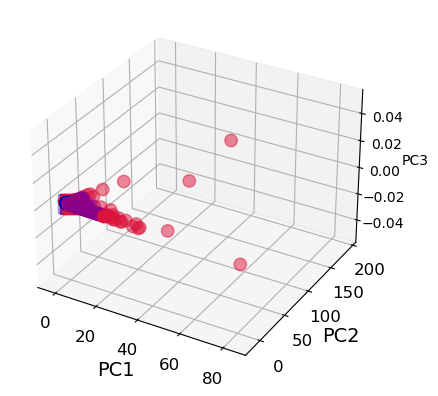

In [148]:
mycmap = ListedColormap(["crimson", "mediumblue", "darkmagenta"])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(d.iloc[:,0], d.iloc[:,1],  marker = 'o', 
            c=d['centroid'].astype('category'), 
            cmap = mycmap, s=80, alpha=0.5)
ax.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
            marker = 's', s=200, c=[0, 1, 2], 
            cmap = mycmap)

ax.set_xlabel(r'PC1', fontsize=14)
ax.set_ylabel(r'PC2', fontsize=14)
ax.set_zlabel(r'PC3')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Let us see the total error by adding all the contributions. We will take a look at this error as a measure of convergence. In other words, if the error does not change, we can assume that the centroids have stabilised their location and we can terminate our iterations. In practice, we need to be mindful of having found a local minimum (outside the scope of this post).

In [150]:
print("The total error is {0:.2f}".format(d['error'].sum()))

The total error is 1646420041.77


Now that we have a first attempt at defining our clusters, we need to update the position of the k centroids. We do this by calculating the mean of the position of the observations assigned to each centroid. Let take a look:

In [151]:
centroids = d.groupby('centroid').agg('mean').loc[:, colnames].reset_index(drop = True)
centroids

,PC1,PC2,PC3
0,0.562886,1.113547,4.061381
1,-0.385752,-0.130241,-0.333051
2,1.646763,0.065798,-0.607774


Now we go back to calculate the distance to each centroid, assign observations and update the centroid location. This calls for a function to encapsulate the loop:

In [152]:
def kmeans(dset, k=2, tol=1e-4):
    '''
    K-means implementationd for a 
    `dset`:  DataFrame with observations
    `k`: number of clusters, default k=2
    `tol`: tolerance=1E-4
    '''
    # Let us work in a copy, so we don't mess the original
    working_dset = dset.copy()
    # We define some variables to hold the error, the 
    # stopping signal and a counter for the iterations
    err = []
    goahead = True
    j = 0
    
    # Step 2: Initiate clusters by defining centroids 
    centroids = initiate_centroids(k, dset)

    while(goahead):
        # Step 3 and 4 - Assign centroids and calculate error
        working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids) 
        err.append(sum(j_err))
        
        # Step 5 - Update centroid position
        centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)

        # Step 6 - Restart the iteration
        if j>0:
            # Is the error less than a tolerance (1E-4)
            if err[j-1]-err[j]<=tol:
                goahead = False
        j+=1

    working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids)
    centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)
    return working_dset['centroid'], j_err, centroids

In [153]:
np.random.seed(42)
d['centroid'], d['error'], centroids =  kmeans(d[['PC1','PC2','PC3']], 3)
d.head()

/var/folders/zz/kmfgmg0s6dlfjck_41bc4rz80000gn/T/ipykernel_22398/1693686515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['centroid'], d['error'], centroids =  kmeans(d[['PC1','PC2','PC3']], 3)


,PC1,PC2,PC3,centroid,error
0,-0.069802,0.279170,3.292534,0,0.139234
1,0.005253,-0.291060,-0.616912,1,0.001241
2,-0.645829,0.481751,3.181510,0,0.108992
3,-0.510154,-0.253351,-0.677062,1,0.048798
4,1.199780,-0.302040,-0.476856,1,2.733159


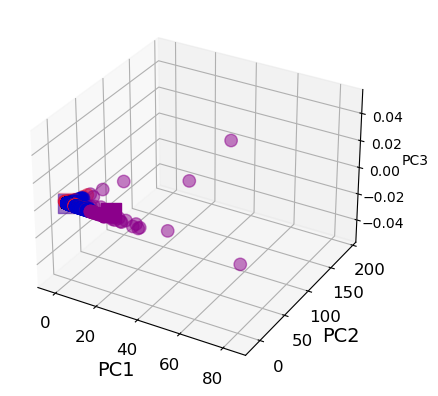

In [154]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(d.iloc[:,0], d.iloc[:,1],  marker = 'o', 
            c=d['centroid'].astype('category'), 
            cmap = mycmap, s=80, alpha=0.5)
ax.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
            marker = 's', s=200, c=[0, 1, 2], 
            cmap = mycmap)

ax.set_xlabel(r'PC1', fontsize=14)
ax.set_ylabel(r'PC2', fontsize=14)
ax.set_zlabel(r'PC3')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

We can use a screen plot to help us with the error minimisation by looking at running the algorithm with a sequence 
k = 1,2,3,4,... and look for the “elbow” in the plot indicating a good number of clusters to use:

In [ ]:
err_total = []
n = 10

df_elbow = d[['PC1','PC2','PC3']]

for i in range(n):
    _, my_errs, _ = kmeans(df_elbow, i+1)
    err_total.append(sum(my_errs))
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1,n+1), err_total, linewidth=3, marker='o')
ax.set_xlabel(r'Number of clusters', fontsize=14)
ax.set_ylabel(r'Total error', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### 2.3.4

Then, use the already implemented version of K-means++ (from the scikit-learn library). Explain the differences (if there are any) in the results.

In [100]:
from sklearn.cluster import KMeans

- <b>Find the Optimal Number of Clusters Using Elbow Method</b>

The elbow method is a heuristic method of interpretation and validation of consistency within cluster analysis designed to help find the appropriate number of clusters in a dataset.

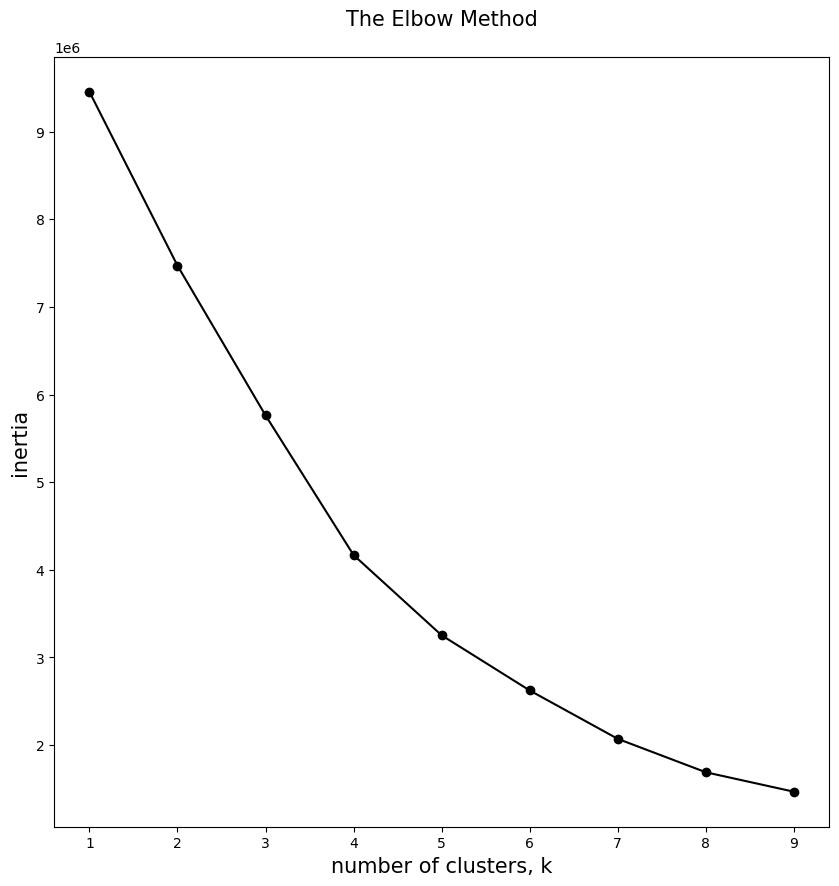

In [101]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(df_pca.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.figure(figsize = (10,10)) 
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k', fontsize = 15, color='black')
plt.ylabel('inertia', fontsize = 15, color='black')
plt.xticks(ks)
plt.title('The Elbow Method', fontsize = 15, color='black', y=1.03);
plt.show()

If the line chart looks like an arm, then the "elbow" on the arm is the value of k that is the best. We find that the "elbow" is in k = 4.

In [102]:
kmeans = KMeans(init="k-means++", n_clusters=4, n_init=10, random_state=1)

#fit k-means algorithm to data
kmeans.fit(df_pca)

#view cluster assignments for each observation
kmeans.labels_

array([3, 0, 3, ..., 0, 0, 0], dtype=int32)

In [103]:
df_pca['Cluster'] = kmeans.labels_

#view updated DataFrame
print(df_pca)

             PC1       PC2       PC3  Cluster
0      -0.069802  0.279170  3.292534        3
1       0.005253 -0.291060 -0.616912        0
2      -0.645829  0.481751  3.181510        3
3      -0.510154 -0.253351 -0.677062        0
4       1.199780 -0.302040 -0.476856        0
...          ...       ...       ...      ...
785487 -0.329977 -0.266325 -0.655442        0
785488 -0.234387  0.006935 -0.673379        0
785489 -0.422663 -0.032040 -0.690395        0
785490 -0.483459 -0.247986 -0.674225        0
785491 -0.500155 -0.190714 -0.683092        0

[785492 rows x 4 columns]


### 2.4 Analysing your results!

In [104]:
a_df  = pd.DataFrame()

In [105]:
a_df = pd.merge(df, df_pca, left_index=True, right_index=True)
a_df = a_df[["CustomerID", "Cluster"]]

We chose two different variables to do the "Characterizing Cluster" step:
- "CustGender": this can only be divided in two categories (Females and Males).
- "AverageBalance": we divided this features in four categories, computing the Pandas qcut function to find three quantiles and divide the distribution of the mean balance for each CustomerID in different categories.

##### CustGender

In [106]:
firstVariable = pd.merge(data, a_df, on="CustomerID")

In [107]:
firstVariable = firstVariable[["CustomerID", "CustGender", "Cluster"]]

In [108]:
firstVariable

,CustomerID,CustGender,Cluster
0,C5841053,1,0
1,C2142763,0,3
2,C4417068,1,0
3,C5342380,1,0
4,C5342380,0,0
...,...,...,...
863481,C5028150,0,0
863482,C1034220,0,3
863483,C8020229,0,0
863484,C6459278,0,0


In [109]:
Cluster0F = 0
Cluster0M = 0
Cluster1F = 0
Cluster1M = 0
Cluster2F = 0
Cluster2M = 0
Cluster3F = 0
Cluster3M = 0

for row in range(len(firstVariable)):
    if firstVariable["Cluster"][row] == 0:
        if firstVariable["CustGender"][row] == 0:
            Cluster0M += 1
        else:
            Cluster0F += 1
    if firstVariable["Cluster"][row] == 1:
        if firstVariable["CustGender"][row] == 0:
            Cluster1M += 1
        else:
            Cluster1F += 1
    if firstVariable["Cluster"][row] == 2:
        if firstVariable["CustGender"][row] == 0:
            Cluster2M += 1
        else:
            Cluster2F += 1
    if firstVariable["Cluster"][row] == 3:
        if firstVariable["CustGender"][row] == 0:
            Cluster3M += 1
        else:
            Cluster3F += 1

In [110]:
Cluster0 = Cluster0F + Cluster0M
Cluster1 = Cluster1F + Cluster1M
Cluster2 = Cluster2F + Cluster2M
Cluster3 = Cluster3F + Cluster3M

We computed the number of Females and Males in each cluster and then the sum of people in every cluster.
This will be helpful to calculate the percentages and create the pivot table.

In [111]:
first = {'Cluster': [0, 1, 2, 3],
        'Females': [(Cluster0F/Cluster0)*100, (Cluster1F/Cluster1)*100, (Cluster2F/Cluster2)*100, (Cluster3F/Cluster3)*100],
        'Males': [(Cluster0M/Cluster0)*100, (Cluster1M/Cluster1)*100, (Cluster2M/Cluster2)*100, (Cluster3M/Cluster3)*100]}

In [112]:
from tabulate import tabulate
head = ["Cluster", "Females %", 'Males %']
print(tabulate(first, headers = head, tablefmt = "grid"))

+-----------+-------------+-----------+
|   Cluster |   Females % |   Males % |
+===========+=============+===========+
|         0 |     27.7188 |   72.2812 |
+-----------+-------------+-----------+
|         1 |     27.7431 |   72.2569 |
+-----------+-------------+-----------+
|         2 |     26.6667 |   73.3333 |
+-----------+-------------+-----------+
|         3 |     27.6826 |   72.3174 |
+-----------+-------------+-----------+


We notice that the clustering created a similar division between females and males, every cluster has approximately 72% of males and 28% of females.

##### AverageBalance

In [113]:
secondVariable = pd.merge(df, a_df, on="CustomerID")

In [114]:
secondVariable = secondVariable[["CustomerID", "AverageBalance", "Cluster"]]

In [115]:
secondVariable

,CustomerID,AverageBalance,Cluster
0,C1010011,1022.105,3
1,C1010012,324.070,0
2,C1010014,1340.385,3
3,C1010018,6.640,0
4,C1010024,1165.610,0
...,...,...,...
734805,C8549960,0.900,0
734806,C8549967,0.900,0
734807,C8550037,432.960,0
734808,C8550052,378.570,0


In [116]:
quant = pd.qcut(secondVariable["AverageBalance"], 3).cat.categories.right
quant

Float64Index([117.16, 495.9, 1540181.14], dtype='float64')

In [117]:
balances0 = [0]*4
balances1 = [0]*4
balances2 = [0]*4
balances3 = [0]*4

for row in range(len(secondVariable)):
    if secondVariable["Cluster"][row] == 0:
        if secondVariable["AverageBalance"][row] < quant[0]:
            balances0[0] += 1
        if secondVariable["AverageBalance"][row] < quant[1] and secondVariable["AverageBalance"][row] > quant[0]:
            balances0[1] += 1
        if secondVariable["AverageBalance"][row] < quant[2] and secondVariable["AverageBalance"][row] > quant[1]:
            balances0[2] += 1
        else:
            balances0[3] += 1
    if secondVariable["Cluster"][row] == 1:
        if secondVariable["AverageBalance"][row] < quant[0]:
            balances1[0] += 1
        if secondVariable["AverageBalance"][row] < quant[1] and secondVariable["AverageBalance"][row] > quant[0]:
            balances1[1] += 1
        if secondVariable["AverageBalance"][row] < quant[2] and secondVariable["AverageBalance"][row] > quant[1]:
            balances1[2] += 1
        else:
            balances1[3] += 1
    if secondVariable["Cluster"][row] == 2:
        if secondVariable["AverageBalance"][row] < quant[0]:
            balances2[0] += 1
        if secondVariable["AverageBalance"][row] < quant[1] and secondVariable["AverageBalance"][row] > quant[0]:
            balances2[1] += 1
        if secondVariable["AverageBalance"][row] < quant[2] and secondVariable["AverageBalance"][row] > quant[1]:
            balances2[2] += 1
        else:
            balances2[3] += 1
    if secondVariable["Cluster"][row] == 3:
        if secondVariable["AverageBalance"][row] < quant[0]:
            balances3[0] += 1
        if secondVariable["AverageBalance"][row] < quant[1] and secondVariable["AverageBalance"][row] > quant[0]:
            balances3[1] += 1
        if secondVariable["AverageBalance"][row] < quant[2] and secondVariable["AverageBalance"][row] > quant[1]:
            balances3[2] += 1
        else:
            balances3[3] += 1

In [118]:
bal0 = sum(balances0)
bal1 = sum(balances1)
bal2 = sum(balances2)
bal3 = sum(balances3)

We computed the number of people in each interval of "AverageBalance" for every cluster, and then calculated the sum, to finally get the percentage.

In [119]:
second = {'Cluster': [0, 1, 2, 3],
        'Balances under 117': [(balances0[0]/bal0)*100, (balances1[0]/bal1)*100, (balances2[0]/bal2)*100, (balances3[0]/bal3)*100],
        'Balances between 117 and 495': [(balances0[1]/bal0)*100, (balances1[1]/bal1)*100, (balances2[1]/bal2)*100, (balances3[1]/bal3)*100],
        'Balances between 495 and 1540181': [(balances0[2]/bal0)*100, (balances1[2]/bal1)*100, (balances2[2]/bal2)*100, (balances3[2]/bal3)*100],
        'Balances over 1540181': [(balances0[3]/bal0)*100, (balances1[3]/bal1)*100, (balances2[3]/bal2)*100, (balances3[3]/bal3)*100]
        }

In [120]:
from tabulate import tabulate
head = ["Cluster", "Balances<117", 'Balances between 117 and 495', 'Balances between 495 and 1540181', 'Balances>1540181']
print(tabulate(second, headers=head, tablefmt="grid"))

+-----------+----------------+--------------------------------+------------------------------------+--------------------+
|   Cluster |   Balances<117 |   Balances between 117 and 495 |   Balances between 495 and 1540181 |   Balances>1540181 |
+===========+================+================================+====================================+====================+
|         0 |        20.0063 |                        20.0067 |                            19.97   |            40.017  |
+-----------+----------------+--------------------------------+------------------------------------+--------------------+
|         1 |        19.7093 |                        20.3063 |                            19.9689 |            40.0156 |
+-----------+----------------+--------------------------------+------------------------------------+--------------------+
|         2 |        22.3048 |                        18.9591 |                            17.4721 |            41.2639 |
+-----------+-----------

Looking at the distribution of the different ranges of balance according to the cluster of each Customer, we see that it's evenly distributed.

### Performance Evaluation

To compute the performance evaluation of the clustering we use:
- Silhouette Coefficient: it measures how similar an object is to its own cluster compared to other clusters. Its value ranges from -1 to 1; 1 means that clusters are well apart from each other and clearly distinguished.
- Davies-Boulding Index (DBI): it's an internal evaluation scheme, where the validation of how well the clustering has been done is made using quantites and features inherent to the dataset. The minimum score is zero, with lower values indicating better clustering

In [121]:
df_pca_test = df_pca[:10000]

In [122]:
kmeans = KMeans(n_clusters=4)
labels = kmeans.fit_predict(df_pca_test)

In [123]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [124]:
print("Silhouette Coefficient: %0.3f" % silhouette_score(df_pca_test, labels))

Silhouette Coefficient: 0.836


In [125]:
print("Davies-Bouldin Index: %0.3f" % davies_bouldin_score(df_pca_test, labels))

Davies-Bouldin Index: 0.489


We had to run the Silhouette score and the Davies-Bouldin Index score on a test dataset because the full dataset was taking way too long to run. We expect to have similar results for the original dataframe.

The Silhouette Coefficient is equal to 0.8, which is a good score for the clustering. The closer it gets to 1, the better the chosen clusters are. So we can argue that this was a pretty good clustering performance.
Regarding the Davies-Bouldin Index, it is almost equal to 0.5: this score is in the middle but decreasing it would be better for the performance of the model.

We'll try running it on number of clusters = 5, to see how it changes and if that would've gotten a better clustering performance.

In [126]:
kmeans = KMeans(n_clusters=5)
labels = kmeans.fit_predict(df_pca_test)

In [127]:
print("Silhouette Coefficient: %0.3f" % silhouette_score(df_pca_test, labels))

Silhouette Coefficient: 0.837


In [128]:
print("Davies-Bouldin Index: %0.3f" % davies_bouldin_score(df_pca_test, labels))

Davies-Bouldin Index: 0.445


Number of clusters = 6:

In [129]:
kmeans = KMeans(n_clusters=6)
labels = kmeans.fit_predict(df_pca_test)

In [130]:
print("Silhouette Coefficient: %0.3f" % silhouette_score(df_pca_test, labels))

Silhouette Coefficient: 0.851


In [131]:
print("Davies-Bouldin Index: %0.3f" % davies_bouldin_score(df_pca_test, labels))

Davies-Bouldin Index: 0.482


We notice that, increasing the number of clusters, the scores don't change too much.
The best scores we got from these examples are from the number of clusters = 5 (Silhouette Coefficient is -slightly- higher, DBI is lower), meanwhile for number of clusters = 6 we got a higher Silhouette Coefficient but, also, a higher DBI, so that's not the best choice.